In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(1)
tf.random.set_seed(1)


In [2]:
def generate_cosine_data(n=3000, in_seq=15, out_seq=5):
    X, Y = [], []
    for _ in range(n):
        freq = np.random.uniform(0.05, 0.25)
        phase = np.random.uniform(0, 2*np.pi)
        total = in_seq + out_seq
        t = np.linspace(0, total, total)
        signal = np.cos(2 * np.pi * freq * t + phase) + 0.05 * np.random.randn(total)
        X.append(signal[:in_seq].reshape(-1, 1))
        Y.append(signal[in_seq:].reshape(-1, 1))
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

X, Y = generate_cosine_data()

X_train, Y_train = X[:2400], Y[:2400]
X_val,   Y_val   = X[2400:2700], Y[2400:2700]
X_test,  Y_test  = X[2700:], Y[2700:]

print("Train shape:", X_train.shape, Y_train.shape)


Train shape: (2400, 15, 1) (2400, 5, 1)


In [3]:
def build_model(cell_type='RNN', units=64, in_len=15, out_len=5, feat=1):
    encoder_input = Input(shape=(in_len, feat), name='encoder_input')

    if cell_type == 'LSTM':
        encoder, state_h, state_c = LSTM(units, return_state=True)(encoder_input)
        encoder_state = [state_h, state_c]
    elif cell_type == 'GRU':
        encoder, state = GRU(units, return_state=True)(encoder_input)
        encoder_state = [state]
    else:
        encoder, state = SimpleRNN(units, return_state=True)(encoder_input)
        encoder_state = [state]

    decoder_input = RepeatVector(out_len)(encoder)

    if cell_type == 'LSTM':
        decoder = LSTM(units, return_sequences=True)
    elif cell_type == 'GRU':
        decoder = GRU(units, return_sequences=True)
    else:
        decoder = SimpleRNN(units, return_sequences=True)

    decoder_output = decoder(decoder_input, initial_state=encoder_state)
    output = TimeDistributed(Dense(1))(decoder_output)

    model = Model(encoder_input, output, name=f"Model_{cell_type}")
    model.compile(optimizer='adam', loss='mse')
    return model


In [4]:
results = {}

for cell_type in ['RNN', 'LSTM', 'GRU']:
    print(f"\nTraining {cell_type} model...")
    model = build_model(cell_type)
    es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
    t0 = time.time()
    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=50,
                        batch_size=64,
                        callbacks=[es],
                        verbose=0)
    train_time = time.time() - t0
    val_loss = model.evaluate(X_val, Y_val, verbose=0)
    test_loss = model.evaluate(X_test, Y_test, verbose=0)
    results[cell_type] = {
        'model': model,
        'history': history,
        'val_loss': val_loss,
        'test_loss': test_loss,
        'time': train_time
    }
    print(f"{cell_type:<4} | Val MSE: {val_loss:.4f} | Test MSE: {test_loss:.4f} | Time: {train_time:.1f}s")



Training RNN model...
RNN  | Val MSE: 0.0061 | Test MSE: 0.0052 | Time: 33.2s

Training LSTM model...
LSTM | Val MSE: 0.0055 | Test MSE: 0.0049 | Time: 52.0s

Training GRU model...
GRU  | Val MSE: 0.0061 | Test MSE: 0.0057 | Time: 63.9s


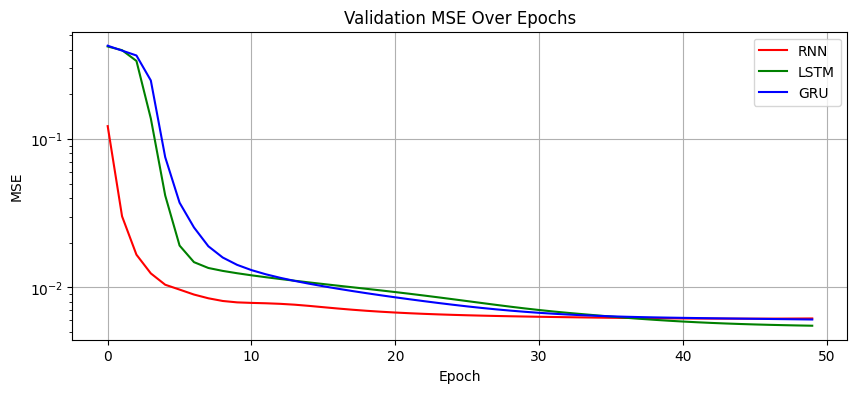

In [5]:
plt.figure(figsize=(10,4))
for cell_type, color in zip(results, ['red', 'green', 'blue']):
    plt.plot(results[cell_type]['history'].history['val_loss'], label=cell_type, color=color)
plt.title('Validation MSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


,Validation MSE,Test MSE,Training Time (s)
RNN,0.006137,0.005249,33.150401
LSTM,0.005499,0.004892,52.048185
GRU,0.006057,0.005708,63.891088


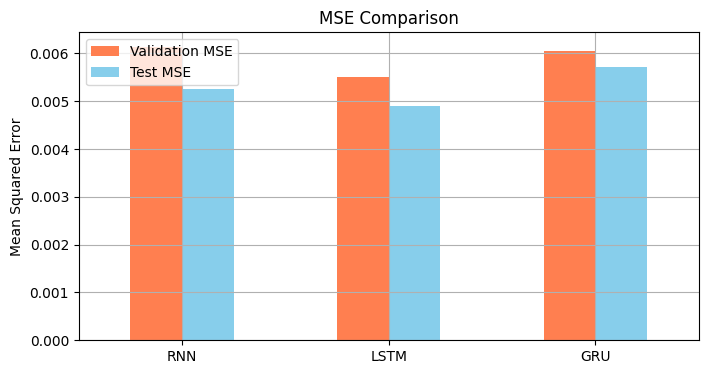

In [6]:
df = pd.DataFrame({
    'Validation MSE': {k: results[k]['val_loss'] for k in results},
    'Test MSE': {k: results[k]['test_loss'] for k in results},
    'Training Time (s)': {k: results[k]['time'] for k in results}
})
display(df)

df[['Validation MSE', 'Test MSE']].plot(kind='bar', figsize=(8,4), color=['coral', 'skyblue'])
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


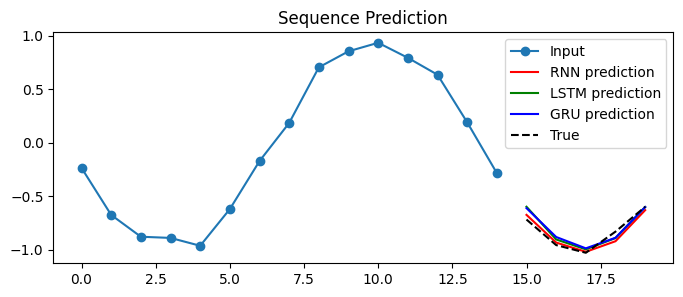

In [7]:
k = 5  # sample index
plt.figure(figsize=(8,3))
plt.plot(range(15), X_test[k,:,0], label='Input', marker='o')

for cell_type, color in zip(results, ['red', 'green', 'blue']):
    pred = results[cell_type]['model'].predict(X_test[k:k+1])[0,:,0]
    plt.plot(range(15,20), pred, label=f'{cell_type} prediction', color=color)

plt.plot(range(15,20), Y_test[k,:,0], label='True', linestyle='--', color='black')
plt.title('Sequence Prediction')
plt.legend()
plt.show()
